Checkpoint 3.1: Implementing fine-tuning of distilRoberta for doing boolean classification over the boolq training set

In [ ]:
!pip install datasets
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader

# Load the dataset
dataset = load_dataset("boolq")

# Initialize the tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('distilroberta-base')

# Define the preprocess function
def preprocess_function(examples):
    # Encode passages and questions
    return tokenizer(examples['passage'], examples['question'], padding="max_length", truncation=True, max_length=512, return_tensors="pt")

# Map the dataset
train_dataset = dataset['train'].map(preprocess_function, batched=True)
valid_dataset = dataset['validation'].map(preprocess_function, batched=True)

# Convert 'answer' to int and adjust dataset format for PyTorch
def format_dataset(dataset):
    dataset = dataset.map(lambda examples: {'labels': [int(answer) for answer in examples['answer']]}, batched=True)
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    return dataset

train_dataset = format_dataset(train_dataset)
valid_dataset = format_dataset(valid_dataset)

# Initialize the model
model = RobertaForSequenceClassification.from_pretrained('distilroberta-base', num_labels=2)
model.train()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

epochs = 4

# Optimizer
optim = AdamW(model.parameters(), lr=5e-5)

total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(optim,
                                            num_warmup_steps=100,  # Adjust as needed
                                            num_training_steps=total_steps)

train_losses = []  # List to store average loss per epoch

for epoch in range(epochs):  # Train for 4 epochs
    epoch_losses = []  # Store losses for each epoch
    for batch in train_loader:
        optim.zero_grad()

        # Move batch to the same device as model
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)

        loss = outputs.loss
        loss.backward()
        optim.step()
        scheduler.step()

        epoch_losses.append(loss.item())

    # Calculate the average loss for the epoch
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    train_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1} loss: {avg_epoch_loss}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 loss: 0.6660365499208497
Epoch 2 loss: 0.6546833630433216
Epoch 3 loss: 0.6146503779800186
Epoch 4 loss: 0.5293168492672098


3.1 : Training loss curve

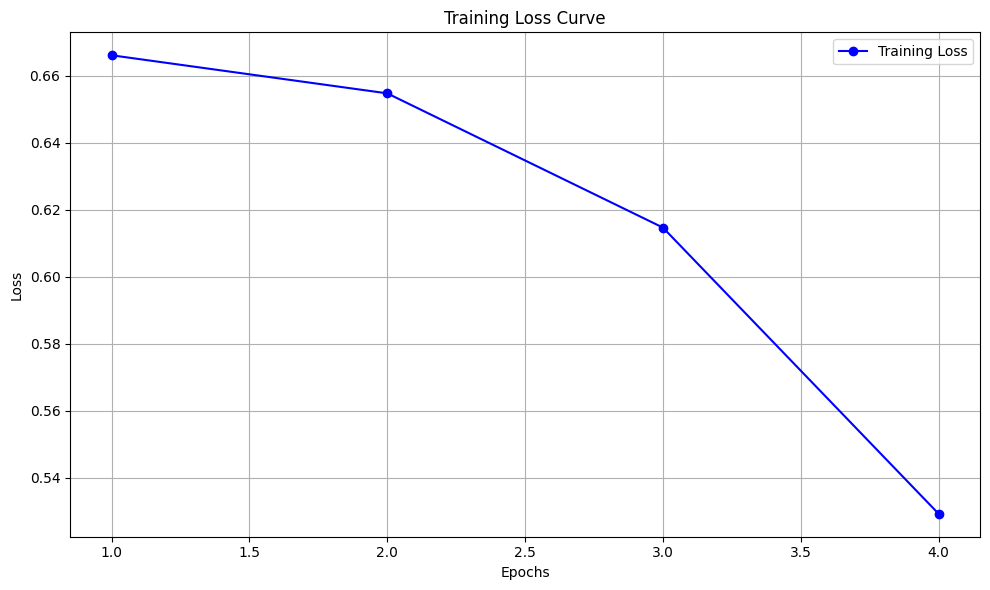

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o', linestyle='-', color='blue')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_loss_curve.png')
plt.show()


3.1 : overall accuracy and F1 scores

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

valid_loader = DataLoader(valid_dataset, batch_size=8)

# To ensure model is in evaluation mode
model.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for batch in valid_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')
class_specific_metrics = precision_recall_fscore_support(true_labels, predictions, labels=[1, 0])

print(f"Overall: acc: {accuracy:.3f}, f1: {f1:.3f}")

print(f"\n    Yes: prec: {class_specific_metrics[0][1]:.3f}, rec: {class_specific_metrics[1][1]:.3f},  f1: {class_specific_metrics[2][1]:.3f}")

print(f"\n     No: prec: {class_specific_metrics[0][0]:.3f}, rec: {class_specific_metrics[1][0]:.3f},  f1: {class_specific_metrics[2][0]:.3f}")

Overall: acc: 0.671, f1: 0.745

    Yes: prec: 0.575, rec: 0.500,  f1: 0.535

     No: prec: 0.718, rec: 0.775,  f1: 0.745


Checkpoint 3.2 : Implementing fine-tuning of distilRoberta for doing regression using the emoBank-valence training set along with the training loss curve

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for Blablablab/SOCKET contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Blablablab/SOCKET
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

9002
9002


Generating test split: 0 examples [00:00, ? examples/s]

550
550


Generating validation split: 0 examples [00:00, ? examples/s]

510
510


Generating sockette split: 0 examples [00:00, ? examples/s]

550
550


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Map:   0%|          | 0/9002 [00:00<?, ? examples/s]

Map:   0%|          | 0/550 [00:00<?, ? examples/s]

Map:   0%|          | 0/510 [00:00<?, ? examples/s]

Map:   0%|          | 0/550 [00:00<?, ? examples/s]

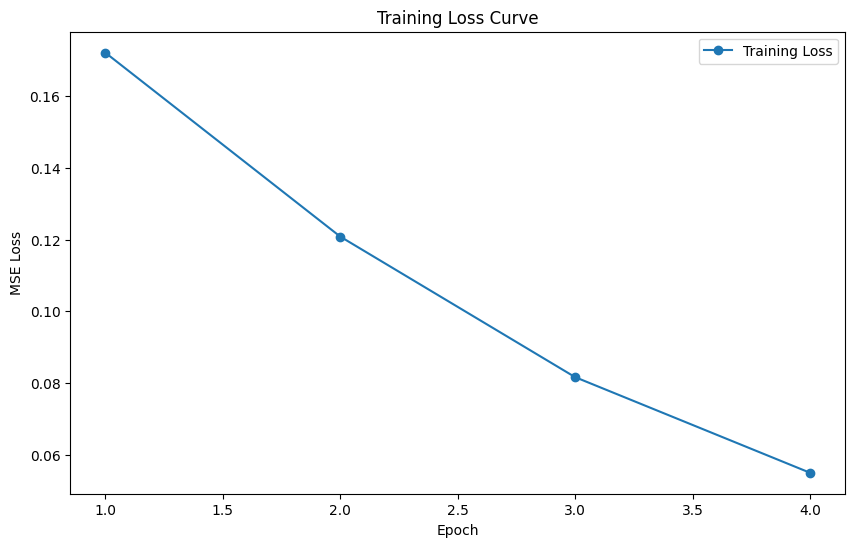

In [ ]:
from transformers import RobertaConfig
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Load the dataset
emo_dataset = load_dataset('Blablablab/SOCKET', 'emobank#valence')

# Initialize tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('distilroberta-base')

# Preprocessing function
def preprocess_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=300)

# Apply preprocessing
emo_dataset = emo_dataset.map(preprocess_function, batched=True)

train_test_split = emo_dataset['train'].train_test_split(test_size=0.3)
train_dataset = train_test_split['train']
valid_dataset = train_test_split['test']

# Adjustment made  for regression
class DistilRobertaForRegression(nn.Module):
    def __init__(self):
        super(DistilRobertaForRegression, self).__init__()
        self.config = RobertaConfig.from_pretrained('distilroberta-base')
        self.distilroberta = RobertaForSequenceClassification(self.config).roberta
        self.regression = nn.Linear(self.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.distilroberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0][:,0,:]  # Use the output of the [CLS] token
        logits = self.regression(sequence_output)
        return logits

model = DistilRobertaForRegression()

if torch.cuda.is_available():
    model.cuda()

# Converting datasets to torch format
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
valid_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=5)

# Training setup
optimizer = AdamW(model.parameters(), lr=5e-5)
mse_loss = torch.nn.MSELoss()

# Training loop
model.train()
epoch_losses = []

for epoch in range(4):
    batch_losses = []
    for batch in train_loader:
        input_ids = batch['input_ids'].to(torch.device("cuda"))
        attention_mask = batch['attention_mask'].to(torch.device("cuda"))
        labels = batch['label'].unsqueeze(-1).to(torch.device("cuda"))

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = mse_loss(outputs, labels.float())
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    epoch_loss = sum(batch_losses) / len(batch_losses)
    epoch_losses.append(epoch_loss)

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


3.2 : overall mean absolute error along with Pearson correlation r

In [ ]:
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from datasets import DatasetDict

# Splitting the 'train' data into train and test sets
train_testvalid = emo_dataset["train"].train_test_split(test_size=0.3)  # Splitting off test set
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)  # Splitting the remainder into test and validation

# Constructing a new DatasetDict
split_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
})

split_dataset = split_dataset.map(preprocess_function, batched=True)

# Setting the format
split_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


train_loader = DataLoader(split_dataset['train'], batch_size=16, shuffle=True)
valid_loader = DataLoader(split_dataset['validation'], batch_size=16)
test_loader = DataLoader(split_dataset['test'], batch_size=16)

def evaluate(model, loader):
    model.eval()
    predictions, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            attention_mask = batch['attention_mask'].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

            # Forward pass, get model output
            outputs = model(input_ids, attention_mask)


            predictions.extend(outputs.view(-1).cpu().numpy())
            labels.extend(batch['label'].cpu().numpy())

    return predictions, labels

# Evaluation on validation set
val_predictions, val_labels = evaluate(model, valid_loader)
val_mae = mean_absolute_error(val_labels, val_predictions)
val_pearson = pearsonr(val_labels, val_predictions)[0]

# Evaluation on test set
test_predictions, test_labels = evaluate(model, test_loader)
test_mae = mean_absolute_error(test_labels, test_predictions)
test_pearson = pearsonr(test_labels, test_predictions)[0]

print(f"Validation: MAE: {val_mae:.3f}, r: {val_pearson:.3f}")
print(f"Test: MAE: {test_mae:.3f}, r: {test_pearson:.3f}")



Map:   0%|          | 0/6301 [00:00<?, ? examples/s]

Map:   0%|          | 0/1350 [00:00<?, ? examples/s]

Map:   0%|          | 0/1351 [00:00<?, ? examples/s]

Validation: MAE: 0.157, r: 0.779
Test: MAE: 0.161, r: 0.761


Checkpoint 3.3.1 : distilRB-rand transform model

In [ ]:
# Initializing model
distilRB_rand = RobertaForSequenceClassification.from_pretrained('distilroberta-base', num_labels=2)

# Define your custom weight initialization function
def custom_weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
    elif isinstance(m, (nn.LayerNorm, nn.BatchNorm1d, nn.BatchNorm2d)):
        nn.init.constant_(m.weight, 1.0)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

# Applying the custom weight initialization
distilRB_rand.apply(custom_weights_init)
distilRB_rand.save_pretrained('./distilRB-rand')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
dataset = load_dataset("boolq")

# Initialize the tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('distilroberta-base')

# Define the preprocess function
def preprocess_function(examples):
    # Encode passages and questions
    return tokenizer(examples['passage'], examples['question'], padding="max_length", truncation=True, max_length=30, return_tensors="pt")

# Map the dataset
train_dataset = dataset['train'].map(preprocess_function, batched=True)
valid_dataset = dataset['validation'].map(preprocess_function, batched=True)


def format_dataset(dataset):
    dataset = dataset.map(lambda examples: {'labels': [int(answer) for answer in examples['answer']]}, batched=True)
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    return dataset

train_dataset = format_dataset(train_dataset)
valid_dataset = format_dataset(valid_dataset)

# Initialize the model
model_path = './distilRB-rand'
model = RobertaForSequenceClassification.from_pretrained(model_path, num_labels=2)
model.train()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

epochs = 4

# Optimizer
optim = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optim,
                                            num_warmup_steps=100,  # Adjust as needed
                                            num_training_steps=total_steps)
train_losses = []  # List to store average loss per epoch

for epoch in range(epochs):  # Train for 4 epochs
    epoch_losses = []  # Store losses for each epoch
    for batch in train_loader:
        optim.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)

        loss = outputs.loss
        loss.backward()
        optim.step()
        scheduler.step()

        epoch_losses.append(loss.item())

    # Calculate the average loss for the epoch
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    train_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1} loss: {avg_epoch_loss}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 loss: 0.7432425587383124
Epoch 2 loss: 0.7140687985861761
Epoch 3 loss: 0.7119996818726884
Epoch 4 loss: 0.6876416740133745


3.3.1 : visualizing training loss curve via fine-tuning over the dataset

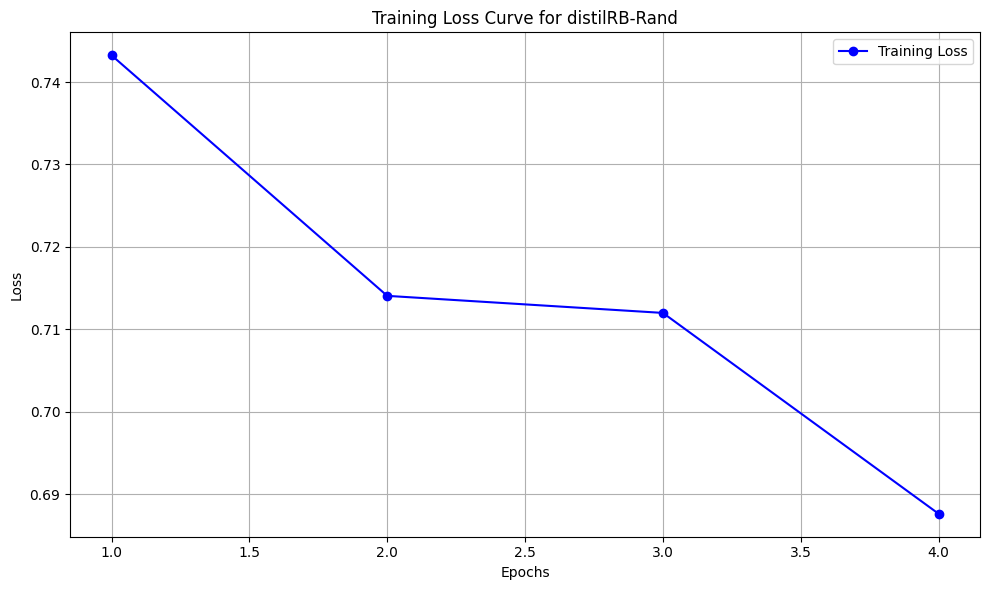

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o', linestyle='-', color='blue')
plt.title('Training Loss Curve for distilRB-Rand')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_loss_curve.png')
plt.show()

3.3.2 : Implementation of distilRB-KQ model

In [ ]:
import math
from transformers import RobertaModel


class CustomSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Using a single linear layer for both query and key
        self.query_key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask=None):
        mixed_query_key_layer = self.query_key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_key_layer)
        key_layer = self.transpose_for_scores(mixed_query_key_layer)  # Shared weights used here
        value_layer = self.transpose_for_scores(mixed_value_layer)

        #score calculation
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        return context_layer

class DistilRBKQ(RobertaModel):
    def __init__(self, config):
        super().__init__(config)
        for i, layer in enumerate(self.roberta.encoder.layer):
            self.roberta.encoder.layer[i].attention.self = CustomSelfAttention(config)

config = RobertaConfig.from_pretrained('distilroberta-base')
model = RobertaModel(config)
model.save_pretrained('./distilRB-KQ')
model_path = './distilRB-KQ'
model = RobertaForSequenceClassification.from_pretrained(model_path, num_labels=2)

In [ ]:
# Load the dataset
dataset = load_dataset("boolq")

# Initialize the tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('distilroberta-base')

# Define the preprocess function
def preprocess_function(examples):
    # Encode passages and questions
    return tokenizer(examples['passage'], examples['question'], padding="max_length", truncation=True, max_length=30, return_tensors="pt")

# Map the dataset
train_dataset = dataset['train'].map(preprocess_function, batched=True)
valid_dataset = dataset['validation'].map(preprocess_function, batched=True)

def format_dataset(dataset):
    dataset = dataset.map(lambda examples: {'labels': [int(answer) for answer in examples['answer']]}, batched=True)
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    return dataset

train_dataset = format_dataset(train_dataset)
valid_dataset = format_dataset(valid_dataset)

# Initialize the model
model_path = './distilRB-KQ'
model = RobertaForSequenceClassification.from_pretrained(model_path, num_labels=2)
model.train()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

epochs = 4
# Optimizer
optim = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optim,
                                            num_warmup_steps=100,  # Adjust as needed
                                            num_training_steps=total_steps)
train_losses = []  # List to store average loss per epoch

for epoch in range(epochs):  # Train for 4 epochs
    epoch_losses = []  # Store losses for each epoch
    for batch in train_loader:
        optim.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)

        loss = outputs.loss
        loss.backward()
        optim.step()
        scheduler.step()

        epoch_losses.append(loss.item())

    # Calculate the average loss for the epoch
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    train_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1} loss: {avg_epoch_loss}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./distilRB-KQ and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 loss: 0.6850148833342278
Epoch 2 loss: 0.6743739990483717
Epoch 3 loss: 0.670482070865883
Epoch 4 loss: 0.6693589992197767


3.2.2 : visualizing training loss curve via fine-tuning over the dataset

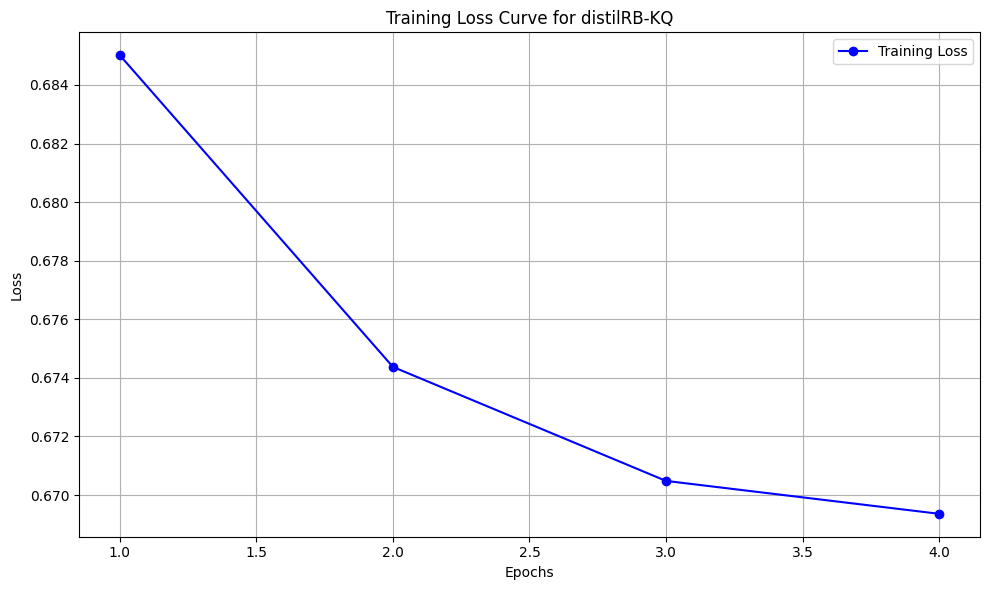

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o', linestyle='-', color='blue')
plt.title('Training Loss Curve for distilRB-KQ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_loss_curve.png')
plt.show()

3.3.3 : Implementing distilRB-nores model

In [ ]:
class CustomTransformerLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=config.hidden_size, num_heads=config.num_attention_heads)
        self.norm1 = nn.LayerNorm(config.hidden_size)
        self.norm2 = nn.LayerNorm(config.hidden_size)
        self.ff = nn.Linear(config.hidden_size, config.hidden_size)

    def forward(self, x):
        # Self-attention
        attn_output, _ = self.self_attn(x, x, x)
        out1 = self.norm1(attn_output)

        # Feedforward
        ff_output = self.ff(out1)
        out2 = self.norm2(ff_output)

        return out2

class DistilRBNORes(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = RobertaModel(config).embeddings
        self.transformer_layers = nn.ModuleList([CustomTransformerLayer(config) for _ in range(config.num_hidden_layers)])
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]  # (batch_size, sequence_length, hidden_size)

    # Mean pooling
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(sequence_output.size()).float()
        sum_embeddings = torch.sum(sequence_output * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        mean_embeddings = sum_embeddings / sum_mask

    # Max pooling
        max_embeddings, _ = torch.max(sequence_output, dim=1)

    # Concatenate pooled outputs
        pooled_output = torch.cat((mean_embeddings, max_embeddings), dim=1)

        logits = self.classifier(pooled_output)

        return logits


config = RobertaConfig.from_pretrained('distilroberta-base', num_labels=2)
distil_rb_nores = DistilRBNORes(config)
model.save_pretrained('./distilRB-nores')
model_path = './distilRB-nores'
model = RobertaForSequenceClassification.from_pretrained(model_path, num_labels=2)

In [ ]:
dataset = load_dataset("boolq")

# Initialize the tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('distilroberta-base')

# Define the preprocess function
def preprocess_function(examples):
    # Encode passages and questions
    return tokenizer(examples['passage'], examples['question'], padding="max_length", truncation=True, max_length=30, return_tensors="pt")

# Map the dataset
train_dataset = dataset['train'].map(preprocess_function, batched=True)
valid_dataset = dataset['validation'].map(preprocess_function, batched=True)

# Convert 'answer' to int and adjust dataset format for PyTorch
def format_dataset(dataset):
    dataset = dataset.map(lambda examples: {'labels': [int(answer) for answer in examples['answer']]}, batched=True)
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    return dataset

train_dataset = format_dataset(train_dataset)
valid_dataset = format_dataset(valid_dataset)

# Initialize the model
model_path = './distilRB-nores'
model = RobertaForSequenceClassification.from_pretrained(model_path, num_labels=2)
model.train()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

epochs = 4
# Optimizer
optim = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optim,
                                            num_warmup_steps=100,  # Adjust as needed
                                            num_training_steps=total_steps)
train_losses = []  # List to store average loss per epoch

for epoch in range(epochs):  # Train for 4 epochs
    epoch_losses = []  # Store losses for each epoch
    for batch in train_loader:
        optim.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optim.step()
        scheduler.step()
        epoch_losses.append(loss.item())

    # Calculate the average loss for the epoch
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    train_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1} loss: {avg_epoch_loss}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 loss: 0.717269355518918
Epoch 2 loss: 0.7095348801990157
Epoch 3 loss: 0.7065439611281386
Epoch 4 loss: 0.6941115149930215


3.3.3 : visualizing training loss curve via fine-tuning over the dataset

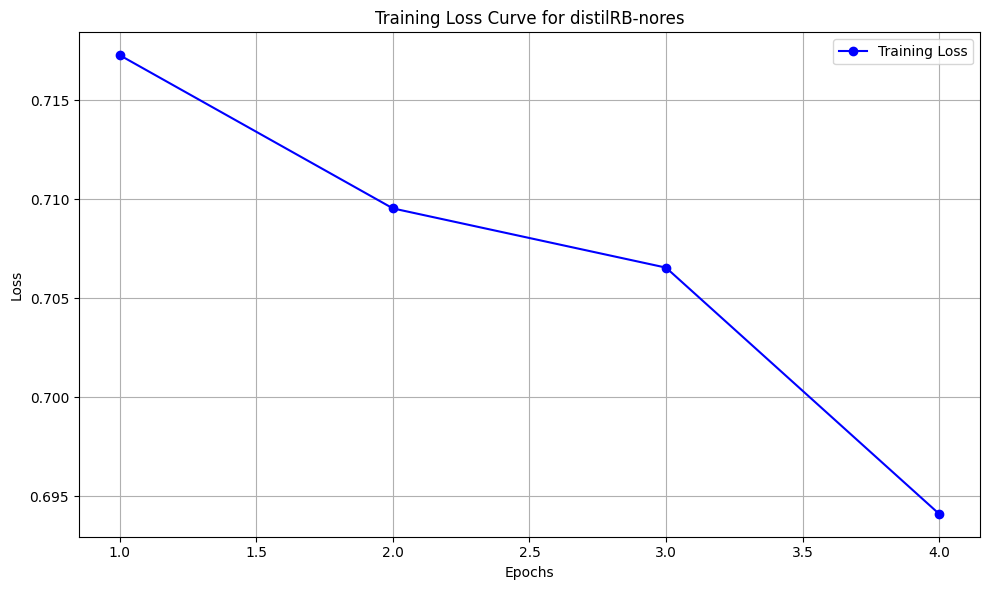

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o', linestyle='-', color='blue')
plt.title('Training Loss Curve for distilRB-nores')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_loss_curve.png')
plt.show()

Checkpoint 3.4 : adjusting different paths for the models for detemining the accuracy and f1 score over the boolQ dataset

In [ ]:
model1_path = './distilRB-rand'
model1 = RobertaForSequenceClassification.from_pretrained(model1_path, num_labels=2)

model2_path = './distilRB-KQ'
model2 = RobertaForSequenceClassification.from_pretrained(model2_path, num_labels=2)

model3_path = './distilRB-nores'
model3 = RobertaForSequenceClassification.from_pretrained(model3_path, num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./distilRB-KQ and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
dataset = load_dataset("boolq")

# Initialize the tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('distilroberta-base')

# Define the preprocess function
def preprocess_function(examples):
    # Encode passages and questions
    return tokenizer(examples['passage'], examples['question'], padding="max_length", truncation=True, max_length=30, return_tensors="pt")

# Map the dataset
train_dataset = dataset['train'].map(preprocess_function, batched=True)
valid_dataset = dataset['validation'].map(preprocess_function, batched=True)

# Convert 'answer' to int and adjust dataset format for PyTorch
def format_dataset(dataset):
    dataset = dataset.map(lambda examples: {'labels': [int(answer) for answer in examples['answer']]}, batched=True)
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    return dataset

train_dataset = format_dataset(train_dataset)
valid_dataset = format_dataset(valid_dataset)

models = {
    "DistilRB-Rand": model1,
    "DistilRB-KQ": model2,
    "DistilRB-nores": model3,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

epochs = 4
# Optimizer
optim = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optim,
                                            num_warmup_steps=100,  # Adjust as needed
                                            num_training_steps=total_steps)
valid_loader = DataLoader(valid_dataset, batch_size=4)

# Function to evaluate a model
def evaluate_model(model_name, model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Move the model to the specified device
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            predictions.extend(preds.cpu().numpy())  # Move predictions back to CPU for further processing
            true_labels.extend(batch['labels'].cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

    print(f"{model_name}: acc: {accuracy:.3f}, f1: {f1:.3f}")

# Loop through each model and evaluate
for model_name, model in models.items():
    evaluate_model(model_name, model, valid_loader, device)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


DistilRB-Rand: acc: 0.380, f1: 0.004
DistilRB-KQ: acc: 0.622, f1: 0.767
DistilRB-nores: acc: 0.602, f1: 0.689


3.4 : Implementing task fine-tuning of distilRB-rand for doing regression using the emoBank-valence training set

In [ ]:
emo_dataset = load_dataset('Blablablab/SOCKET', 'emobank#valence')

# Initialize tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('distilroberta-base')

# Preprocessing function
def preprocess_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=300)

#preprocessing
emo_dataset = emo_dataset.map(preprocess_function, batched=True)

train_test_split = emo_dataset['train'].train_test_split(test_size=0.3)
train_dataset = train_test_split['train']
valid_dataset = train_test_split['test']

# Adjust for regression
class DistilRobertaForRegression(nn.Module):
    def __init__(self):
        super(DistilRobertaForRegression, self).__init__()
        self.config = RobertaConfig.from_pretrained('./distilRB-rand')
        self.distilroberta = RobertaForSequenceClassification(self.config).roberta
        self.regression = nn.Linear(self.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.distilroberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0][:,0,:]
        logits = self.regression(sequence_output)
        return logits

model = DistilRobertaForRegression()

if torch.cuda.is_available():
    model.cuda()

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
valid_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8)

# Training setup
optimizer = AdamW(model.parameters(), lr=5e-5)
mse_loss = torch.nn.MSELoss()

model.train()
train_testvalid = emo_dataset["train"].train_test_split(test_size=0.3)  # Splitting off test set
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)  # Splitting the remainder into test and validation

# Constructing a new DatasetDict
split_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
})

split_dataset = split_dataset.map(preprocess_function, batched=True)

# Setting the format
split_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


train_loader = DataLoader(split_dataset['train'], batch_size=16, shuffle=True)
valid_loader = DataLoader(split_dataset['validation'], batch_size=16)
test_loader = DataLoader(split_dataset['test'], batch_size=16)

def evaluate(model, loader):
    model.eval()
    predictions, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            attention_mask = batch['attention_mask'].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

            # Forward pass, get model output
            outputs = model(input_ids, attention_mask)

            predictions.extend(outputs.view(-1).cpu().numpy())
            labels.extend(batch['label'].cpu().numpy())

    return predictions, labels

# Evaluation on validation set
val_predictions, val_labels = evaluate(model, valid_loader)
val_mae = mean_absolute_error(val_labels, val_predictions)
val_pearson = pearsonr(val_labels, val_predictions)[0]

# Evaluation on test set
test_predictions, test_labels = evaluate(model, test_loader)
test_mae = mean_absolute_error(test_labels, test_predictions)
test_pearson = pearsonr(test_labels, test_predictions)[0]

print(f"Model distilRB-rand")
print(f"Validation: MAE: {val_mae:.3f}, r: {val_pearson:.3f}")
print(f"Test: MAE: {test_mae:.3f}, r: {test_pearson:.3f}")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for Blablablab/SOCKET contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Blablablab/SOCKET
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Map:   0%|          | 0/6301 [00:00<?, ? examples/s]

Map:   0%|          | 0/1350 [00:00<?, ? examples/s]

Map:   0%|          | 0/1351 [00:00<?, ? examples/s]

Model distilRB-rand
Validation: MAE: 2.489, r: 0.027
Test: MAE: 2.466, r: 0.022


3.4 : Implementing task fine-tuning of distilRB-KQ for doing regression using the emoBank-valence training set

In [ ]:
emo_dataset = load_dataset('Blablablab/SOCKET', 'emobank#valence')

# Initialize tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('distilroberta-base')

# Preprocessing function
def preprocess_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=300)

# Apply preprocessing
emo_dataset = emo_dataset.map(preprocess_function, batched=True)

train_test_split = emo_dataset['train'].train_test_split(test_size=0.3)
train_dataset = train_test_split['train']
valid_dataset = train_test_split['test']

# Adjust for regression
class DistilRobertaForRegression(nn.Module):
    def __init__(self):
        super(DistilRobertaForRegression, self).__init__()
        self.config = RobertaConfig.from_pretrained('./distilRB-KQ')
        self.distilroberta = RobertaForSequenceClassification(self.config).roberta
        self.regression = nn.Linear(self.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.distilroberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0][:,0,:]
        logits = self.regression(sequence_output)
        return logits

model = DistilRobertaForRegression()

if torch.cuda.is_available():
    model.cuda()

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
valid_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8)

# Training setup
optimizer = AdamW(model.parameters(), lr=5e-5)
mse_loss = torch.nn.MSELoss()

model.train()

train_testvalid = emo_dataset["train"].train_test_split(test_size=0.3)  # Splitting off test set
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)  # Splitting the remainder into test and validation

# Constructing a new DatasetDict
split_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
})

split_dataset = split_dataset.map(preprocess_function, batched=True)

# Setting the format
split_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


train_loader = DataLoader(split_dataset['train'], batch_size=16, shuffle=True)
valid_loader = DataLoader(split_dataset['validation'], batch_size=16)
test_loader = DataLoader(split_dataset['test'], batch_size=16)

def evaluate(model, loader):
    model.eval()
    predictions, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            attention_mask = batch['attention_mask'].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

            # Forward pass, get model output
            outputs = model(input_ids, attention_mask)

            predictions.extend(outputs.view(-1).cpu().numpy())
            labels.extend(batch['label'].cpu().numpy())

    return predictions, labels

# Evaluation on validation set
val_predictions, val_labels = evaluate(model, valid_loader)
val_mae = mean_absolute_error(val_labels, val_predictions)
val_pearson = pearsonr(val_labels, val_predictions)[0]

# Evaluation on test set
test_predictions, test_labels = evaluate(model, test_loader)
test_mae = mean_absolute_error(test_labels, test_predictions)
test_pearson = pearsonr(test_labels, test_predictions)[0]

print(f"Model distilRB-KQ score")
print(f"Validation: MAE: {val_mae:.3f}, r: {val_pearson:.3f}")
print(f"Test: MAE: {test_mae:.3f}, r: {test_pearson:.3f}")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for Blablablab/SOCKET contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Blablablab/SOCKET
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Map:   0%|          | 0/6301 [00:00<?, ? examples/s]

Map:   0%|          | 0/1350 [00:00<?, ? examples/s]

Map:   0%|          | 0/1351 [00:00<?, ? examples/s]

Model distilRB-KQ score
Validation: MAE: 4.013, r: 0.055
Test: MAE: 4.009, r: 0.071


3.4 : Implementing task fine-tuning of distilRB-nores for doing regression using the emoBank-valence training set

In [ ]:
emo_dataset = load_dataset('Blablablab/SOCKET', 'emobank#valence')

# Initialize tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('distilroberta-base')

# Preprocessing function
def preprocess_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=300)

# Apply preprocessing
emo_dataset = emo_dataset.map(preprocess_function, batched=True)

train_test_split = emo_dataset['train'].train_test_split(test_size=0.3)
train_dataset = train_test_split['train']
valid_dataset = train_test_split['test']

# Adjust for regression
class DistilRobertaForRegression(nn.Module):
    def __init__(self):
        super(DistilRobertaForRegression, self).__init__()
        self.config = RobertaConfig.from_pretrained('./distilRB-nores')
        self.distilroberta = RobertaForSequenceClassification(self.config).roberta
        self.regression = nn.Linear(self.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.distilroberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0][:,0,:]
        logits = self.regression(sequence_output)
        return logits

model = DistilRobertaForRegression()

if torch.cuda.is_available():
    model.cuda()

# Convert datasets to torch format
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
valid_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8)

# Training setup
optimizer = AdamW(model.parameters(), lr=5e-5)
mse_loss = torch.nn.MSELoss()

model.train()

train_testvalid = emo_dataset["train"].train_test_split(test_size=0.3)  # Splitting off test set
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)  # Splitting the remainder into test and validation

# Constructing a new DatasetDict
split_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
})

split_dataset = split_dataset.map(preprocess_function, batched=True)

# Setting the format
split_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


train_loader = DataLoader(split_dataset['train'], batch_size=16, shuffle=True)
valid_loader = DataLoader(split_dataset['validation'], batch_size=16)
test_loader = DataLoader(split_dataset['test'], batch_size=16)

def evaluate(model, loader):
    model.eval()
      # Set the model to evaluation mode
    predictions, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            attention_mask = batch['attention_mask'].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

            # Forward pass, get model output
            outputs = model(input_ids, attention_mask)

            predictions.extend(outputs.view(-1).cpu().numpy())
            labels.extend(batch['label'].cpu().numpy())
    return predictions, labels

# Evaluation on validation set
val_predictions, val_labels = evaluate(model, valid_loader)
val_mae = mean_absolute_error(val_labels, val_predictions)
val_pearson = pearsonr(val_labels, val_predictions)[0]

# Evaluation on test set
test_predictions, test_labels = evaluate(model, test_loader)
test_mae = mean_absolute_error(test_labels, test_predictions)
test_pearson = pearsonr(test_labels, test_predictions)[0]

print(f"Model distilRB-nores score")
print(f"Validation: MAE: {val_mae:.3f}, r: {val_pearson:.3f}")
print(f"Test: MAE: {test_mae:.3f}, r: {test_pearson:.3f}")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for Blablablab/SOCKET contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Blablablab/SOCKET
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Map:   0%|          | 0/6301 [00:00<?, ? examples/s]

Map:   0%|          | 0/1350 [00:00<?, ? examples/s]

Map:   0%|          | 0/1351 [00:00<?, ? examples/s]

Model distilRB-nores score
Validation: MAE: 3.111, r: 0.029
Test: MAE: 3.119, r: 0.030
